## Example 1 ##

NB for theano, start notebook as
```bash
sjd@allxdaq6 ~/code/slm-optimisation $ THEANO_FLAGS='floatX=float64,device=cpu'  ipython notebook
```
### TODO: ###

- explore float32, may be faster.
- incorporate FFT shift
- shift over to pyFFTW
- document this page better
- fix normalisation in library to sensible param-independent form

### Formulation (for reference): ###
$$E_p^{(in)} = A_0 S_p \exp(i \phi_p)$$

$$E_n^{(out)} = \frac{1}{N} \sum_p E_p^{(in)} \exp(-\frac{2\pi i}{N}pn)$$

Gradients: $$\frac{\partial E_n^{(out)}}{\partial \phi_q} = \frac{1}{N} i E_q^{(in)} \exp\left(-\frac{2\pi i}{N}qn\right)$$


An example to demonstrate use of the theano-based gradient descent code.

1) We create and plot a target intensity

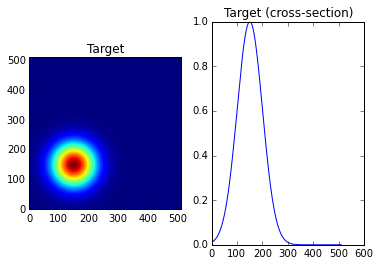

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import theano

%matplotlib inline

def make_target(n, x0, w):
    """
    Create a target intensity size n x n, consisting of a Gaussian centred
    on x0, with width w.
    """
    x = np.array(range(n)) * 1.
    X, Y = np.meshgrid(x, x)

    target = np.exp(-(np.power(X-x0[0],2) + np.power(Y-x0[1],2))/(2*w**2)).astype(theano.config.floatX)
    return target
    
N = 256         # size of SLM is NxN
target = make_target(2*N, x0=(150, 150), w=50);
np.savetxt('slm_target1.txt', target)

plot_args = {'extent':[0, 2*N, 0, 2*N],
             'interpolation':'None',
             'origin': 'lower'}
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(target, vmin=0, vmax=1, **plot_args)
axes[0].set_title('Target')
axes[1].plot(target[150,:])
axes[1].set_title('Target (cross-section)')

In [2]:
# Initialise SLM optimisation class:
import slm
import theano
import theano.tensor as T

from slm import slmOptimisation

# initialise the phase:
def initial_phase(N):
    """ Return a randomised phase array over [0, 2pi]
    """
    return np.random.uniform(low=0, high=2*np.pi, size=(N,N)).astype(theano.config.floatX)

init_phi = initial_phase(N)

s_profile_r = np.ones_like(init_phi).astype(theano.config.floatX)
s_profile_i = np.ones_like(init_phi).astype(theano.config.floatX)
mat_zeros = np.zeros((2*N, 2*N), dtype=theano.config.floatX)

slmOpt = slmOptimisation(target, init_phi, A0=1.0/1000)

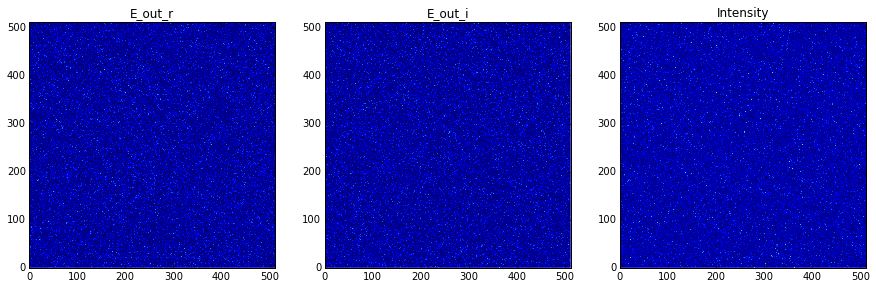

In [3]:
# we now define a cost function to use, squared error for now.
cost = T.sum(T.pow(slmOpt.E_out_2 - target, 2))

# compile a function to calculate cost
f_cost = theano.function([slmOpt.S_r, slmOpt.S_i, slmOpt.zero_matrix], cost, on_unused_input='warn')
f_cost(s_profile_r, s_profile_i, mat_zeros)

# compile field output functions:
f_E_out = theano.function([slmOpt.S_r, slmOpt.S_i, slmOpt.zero_matrix], [slmOpt.E_out_r, slmOpt.E_out_i], on_unused_input='warn')
f_E_out_2 = theano.function([slmOpt.S_r, slmOpt.S_i, slmOpt.zero_matrix], slmOpt.E_out_2, on_unused_input='warn')

# visualise the output given the initial phi field
E_out = f_E_out(s_profile_r, s_profile_i, mat_zeros)
E2_out = f_E_out_2(s_profile_r, s_profile_i, mat_zeros)

fig, (ax1a, ax1b, ax2) = plt.subplots(ncols=3, figsize=(15,15))
ax1a.imshow(E_out[0], vmin=0, vmax=3, **plot_args)
ax1a.set_title('E_out_r')
ax1b.imshow(E_out[1], vmin=0, vmax=3, **plot_args)
ax1b.set_title('E_out_i')
ax2.imshow(E2_out, vmin=0, vmax=3, **plot_args)
ax2.set_title('Intensity');

In [4]:
# create symbolic gradient
grad = T.grad(cost, wrt=slmOpt.phi)

# and define a simple momentum update scheme (as a graph)
l_rate = 0.01   # 'learning rate'
momentum = 0.95 # momentum decay
updates = ((slmOpt.phi, slmOpt.phi - l_rate * slmOpt.phi_rate),
           (slmOpt.phi_rate, momentum*slmOpt.phi_rate + (1.-momentum)*grad))

# now actually compile a function to evaluate this gradient:
print "Compiling update function..."
update = theano.function([slmOpt.S_r, slmOpt.S_i, slmOpt.zero_matrix], 
                         cost, 
                         updates=updates,
                         on_unused_input='warn')
print "...done"

C = update(s_profile_r, s_profile_i, mat_zeros)

Compiling update function...
...done


Initial C: 12803.3156046
0 1.28e+04
100 8.84e+03
200 6.49e+03
300 5.46e+03
400 4.88e+03
500 4.50e+03
600 4.23e+03
700 4.03e+03
800 3.87e+03
900 3.74e+03


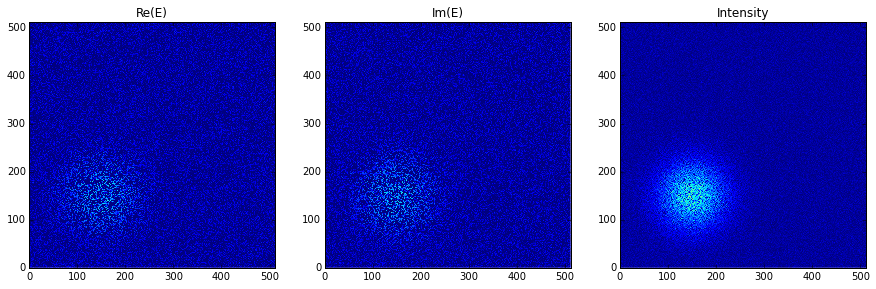

In [5]:
"""
Perform N steps of gradient descent with momentum, and plot
NB you can press Shift + Enter repeatedly on this cell to incrementally
perform the gradient descent.
"""

N_steps = 1000
print 'Initial C: {}'.format(C)
last_C = C
n = 0
for n in range(N_steps):
    C = update(s_profile_r, s_profile_i, mat_zeros)
    if np.mod(n, 100) == 0:
        print '{:d} {:.2e}'.format(n, float(C))

# make plots
E_out = f_E_out(s_profile_r, s_profile_i, mat_zeros)
E2_out = f_E_out_2(s_profile_r, s_profile_i, mat_zeros)

fig, (ax1a, ax1b, ax2) = plt.subplots(ncols=3, figsize=(15,15))
ax1a.imshow(E_out[0], vmin=0, vmax=3, **plot_args)
ax1a.set_title('Re(E)')
ax1b.imshow(E_out[1], vmin=0, vmax=3, **plot_args)
ax1b.set_title('Im(E)')
ax2.imshow(E2_out, vmin=0, vmax=3, **plot_args)
ax2.set_title('Intensity');

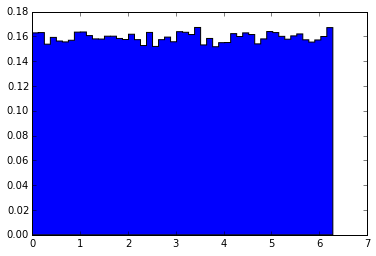

In [6]:
# Check the phase field is sane:
input_phi = np.mod(slmOpt.phi.get_value(), 2*np.pi)
n, bins, patches = plt.hist(input_phi.flatten(), 50, normed=1, histtype='stepfilled')

# Save the phase field:
np.savetxt('slm_input1.txt', input_phi)